In [3]:
%env TT_METAL_HOME=/home/ubuntu/tt-metal
%env TT_METAL_RUNTIME_ROOT=/home/ubuntu/tt-metal

env: TT_METAL_HOME=/home/ubuntu/tt-metal
env: TT_METAL_RUNTIME_ROOT=/home/ubuntu/tt-metal


In [4]:
model_id = "meta-llama/Llama-3.2-1B-Instruct" 
CONFIG = "training_shakespeare_llama3_2_1B_fixed.yaml"
#max lenght 704
#accum 3 (max, 4 oom on n150) 
# broken model 

model_id = "Qwen/Qwen3-1.7B" 
CONFIG = "training_shakespeare_qwen3_1_7B.yaml"

In [5]:
model_id = "Qwen/Qwen3-0.6B" 
CONFIG = "training_shakespeare_qwen3_0_6B.yaml"
#max context 

model_id =  "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"
CONFIG = "training_shakespeare_tinyllama.yaml" # must be working

model_id = "Qwen/Qwen3-4B"
CONFIG = "training_shakespeare_qwen3_4B.yaml"

In [6]:
import ttml

In [7]:
import os
import sys
import datasets
import numpy as np
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from huggingface_hub import hf_hub_download
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import Optional

import ttml
from ttml.common.config import DeviceConfig, get_training_config, load_config
from ttml.common.model_factory import TransformerModelFactory
from ttml.common.utils import round_up_to_tile, create_optimizer, initialize_device
#from ttml import build_causal_mask

#import tt_serialization

In [8]:
def build_causal_mask(T: int):
    m = np.tril(np.ones((T, T), dtype=np.float32))
    return m.reshape(1, 1, T, T)

class SpeedrunScheduler:
    """Linear warmup -> optional hold -> linear decay; optional beta1 warmup."""

    def __init__(self, cfg: SchedulerConfig):
        self.cfg = cfg

    def lr_at(self, step: int) -> float:
        s = step
        w = max(0, self.cfg.warmup_steps)
        h = max(0, self.cfg.hold_steps)
        T = max(1, self.cfg.total_steps)
        peak = self.cfg.max_lr
        min_lr = self.cfg.min_lr

        if s <= w:
            # linear warmup 0 -> lr_max
            return peak * (s / max(1, w))
        elif s <= w + h:
            # hold at lr_max
            return peak
        else:
            # linear decay from lr_max at (w+h) to min_lr at T
            s2 = min(s, T)
            frac = (s2 - (w + h)) / max(1, (T - (w + h)))
            return peak + (min_lr - peak) * frac

    def beta1_at(self, step: int) -> Optional[float]:
        if (
            self.cfg.beta1_start is None
            or self.cfg.beta1_end is None
            or self.cfg.beta1_warmup_steps <= 0
        ):
            return None
        s = min(step, self.cfg.beta1_warmup_steps)
        t = s / float(self.cfg.beta1_warmup_steps)
        return (1.0 - t) * self.cfg.beta1_start + t * self.cfg.beta1_end



In [9]:
class OptimParamSetter:
    def __init__(self, optim):
        self.optim = optim
        self._warned_lr = False
        self._warned_beta1 = False

    def set_lr(self, lr: float):
        self.optim.set_lr(float(lr))

    def set_beta1(self, beta1: float):
        raise NotImplementedError(
            "set_beta1 is not implemented in TTML AdamW optimizer."
        )


def build_logits_mask(vocab_size: int, padded_vocab_size: int) -> ttml.autograd.Tensor:
    logits_mask = np.zeros((1, 1, 1, padded_vocab_size), dtype=np.float32)
    logits_mask[:, :, :, vocab_size:] = 1e4
    return ttml.autograd.Tensor.from_numpy(
        logits_mask, ttml.Layout.TILE, ttml.autograd.DataType.BFLOAT16
    )  # [1,1,1,T], bfloat16"


class CollateFn:
    def __init__(self, eos_token_id, max_sequence_length, padded_vocab_size):
        self.eos_token_id = eos_token_id
        self.max_sequence_length = max_sequence_length
        self.padded_vocab_size = padded_vocab_size

    def collate_fn(self, batch):
        X = [sample[0] for sample in batch]
        Y = [sample[1] for sample in batch]

        batch_size = len(X)

        data_np = np.full(
            (batch_size, self.max_sequence_length), self.eos_token_id, dtype=np.uint32
        )
        mask_lens = []

        for i in range(batch_size):
            x_tokens = X[i]
            y_tokens = Y[i]

            # Concatenate question + answer
            combined_length = len(x_tokens) + len(y_tokens)
            if combined_length > self.max_sequence_length:
                # Truncate if too long, prioritizing keeping the answer
                available_space = self.max_sequence_length - len(y_tokens)
                if available_space > 0:
                    x_tokens = x_tokens[:available_space]
                    data_np[i, : len(x_tokens)] = x_tokens
                    data_np[i, len(x_tokens) : len(x_tokens) + len(y_tokens)] = y_tokens

                else:
                    # If answer is too long, just use the answer
                    data_np[i, : self.max_sequence_length] = y_tokens[
                        : self.max_sequence_length
                    ]
                    x_tokens = []

            else:
                # Normal case: concatenate question + answer

                data_np[i, : len(x_tokens)] = x_tokens
                data_np[i, len(x_tokens) : len(x_tokens) + len(y_tokens)] = y_tokens

            mask_lens.append(len(x_tokens))

        # Shape: [batch_size, 1, 1, max_sequence_length]
        X_np = np.expand_dims(data_np, axis=(1, 2))

        y_np = np.full(
            (batch_size, self.max_sequence_length), self.eos_token_id, dtype=np.uint32
        )  # Shape: [batch, seq_len]
        y_np[:, 0:-1] = X_np[:, 0, 0, 1:]  # Shift left by 1

        loss_scaler_np = np.full(
            (batch_size, 1, self.max_sequence_length, 1), 1.0, dtype=np.float32
        )
        for i, mask_len in enumerate(mask_lens):
            loss_scaler_np[i, :, :mask_len, :] = 0.0
            pad_positions = X_np[i, 0, 0, :] == self.eos_token_id
            loss_scaler_np[i, :, pad_positions, :] = 0.0
        loss_scaler_ratio = (
            self.max_sequence_length * batch_size / np.sum(loss_scaler_np)
        )
        loss_scaler_np = loss_scaler_np * loss_scaler_ratio

        return X_np, y_np, loss_scaler_np

    def __call__(self, batch):
        return self.collate_fn(batch)



In [10]:
def get_batch_generator(
    dataloader,
    batch_size,
    max_sequence_length,
    padded_vocab_size,
    tokenizer,
    device_config=None,
):
    """Custom data generator for GSM8K dataset."""
    mapper = None
    if device_config is not None:
        device = ttml.autograd.AutoContext.get_instance().get_device()
        mapper = ttml.core.distributed.shard_tensor_to_mesh_mapper(device, 0)

    while True:
        for batch in dataloader:
            X_np, y_np, loss_scaler_np = batch

            X = ttml.autograd.Tensor.from_numpy(
                X_np, ttml.Layout.ROW_MAJOR, ttml.autograd.DataType.UINT32, mapper
            )
            y = ttml.autograd.Tensor.from_numpy(
                y_np, ttml.Layout.ROW_MAJOR, ttml.autograd.DataType.UINT32, mapper
            )
            loss_scaler = ttml.autograd.Tensor.from_numpy(
                loss_scaler_np,
                ttml.Layout.TILE,
                ttml.autograd.DataType.BFLOAT16,
                mapper,
            )

            yield (X, y, loss_scaler)


In [11]:
def generate_text_tt(
    model,
    tokenizer,
    question,
    max_sequence_length,
    causal_mask,
    temperature,
    logits_mask_tensor,
    max_gen_tokens,
    pad_token_id=None,
    return_with_prompt=False,
):
    """
    Greedy/temperature=0 generation that prints the *full* text once at the end.
    Uses a sliding window if prompt exceeds max_sequence_length.
    """
    model.eval()
    ttml.autograd.AutoContext.get_instance().set_gradient_mode(
        ttml.autograd.GradMode.DISABLED
    )

    # --- Tokenize once ---
    prompt_tokens = tokenizer.encode(question)
    if pad_token_id is None:
        # Try tokenizer.pad_token_id, else fall back to 0
        pad_token_id = getattr(tokenizer, "pad_token_id", None)
        if pad_token_id is None:
            pad_token_id = 0

    generated_tokens = []

    device = ttml.autograd.AutoContext.get_instance().get_device()
    composer = ttml.core.distributed.concat_mesh_to_tensor_composer(device, 0)

    # Preallocate once
    padded_prompt_tokens = np.full(
        (1, 1, 1, max_sequence_length), pad_token_id, dtype=np.uint32
    )
    for _ in tqdm(range(max_gen_tokens)):
        # Sliding window for long prompts
        if len(prompt_tokens) > max_sequence_length:
            start_idx = len(prompt_tokens) - max_sequence_length
            window = prompt_tokens[start_idx:]
        else:
            start_idx = 0
            window = prompt_tokens

        # Refill buffer (fully) to avoid stale ids
        padded_prompt_tokens[...] = pad_token_id
        padded_prompt_tokens[0, 0, 0, : len(window)] = np.asarray(
            window, dtype=np.uint32
        )

        # [1,1,1,T] -> TT tensor
        padded_prompt_tensor = ttml.autograd.Tensor.from_numpy(
            padded_prompt_tokens, ttml.Layout.ROW_MAJOR, ttml.autograd.DataType.UINT32
        )

        # Forward: logits [1,1,T,V]
        logits = model(padded_prompt_tensor, causal_mask)

        # Sample: next tokens for all positions [1,1,T,1]
        # With temperature=0.0 this behaves like argmax/greedy.
        next_token_tensor = ttml.ops.sample.sample_op(
            logits, 0.0, np.random.randint(low=1e7), logits_mask_tensor
        )

        # Take the token at the last active position in the current window
        next_token_idx = (
            max_sequence_length - 1
            if len(prompt_tokens) > max_sequence_length
            else len(window) - 1
        )
        next_token = int(
            next_token_tensor.to_numpy(composer=composer).reshape(-1, 1)[
                next_token_idx
            ][0]
        )

        if next_token == tokenizer.eos_token_id:
            break

        generated_tokens.append(next_token)
        prompt_tokens.append(next_token)

    # Decode once at the end
    out = tokenizer.decode(generated_tokens)
    if return_with_prompt:
        out = tokenizer.decode(prompt_tokens)

    ttml.autograd.AutoContext.get_instance().set_gradient_mode(
        ttml.autograd.GradMode.ENABLED
    )
    return out


In [12]:
def validate(
    tt_model,
    tokenizer,
    val_batch_generator,
    testing_data,
    loss_fn,
    causal_mask,
    logits_mask_tensor,
    max_sequence_length,
    max_gen_tokens,
    current_step,
):
    reduce = ttml.ops.ReduceType.NONE
    ttml.autograd.AutoContext.get_instance().set_gradient_mode(
        ttml.autograd.GradMode.DISABLED
    )
    tt_model.eval()
    eval_batch_count = 4
    cur_val_losses = []
    for _ in range(eval_batch_count):
        val_X, val_y, val_loss_scaler = next(val_batch_generator)
        val_logits = tt_model(val_X, causal_mask)

        # Compute validation loss
        val_loss = loss_fn(val_logits, val_y, reduce)
        val_loss = val_loss * val_loss_scaler
        val_loss = ttml.ops.unary.mean(val_loss)
        cur_val_losses.append(get_loss_over_devices(val_loss))

    checks_count = 4

    with open("validation.txt", "a+") as val_file:
        val_file.write(f"Validation at step {current_step}\n")
        for check in range(checks_count):
            val_file.write(f"Validation check: {check}\n")
            val_file.write("====================================\n")

            tokenized_question, tokenized_answer = testing_data[check]
            question = tokenizer.decode(tokenized_question, skip_special_tokens=True)

            val_file.write(f"Question: {question}\n")
            val_file.write("====================================\n")

            gen_text = generate_text_tt(
                tt_model,
                tokenizer,
                question,
                max_sequence_length,
                causal_mask,
                0.0,
                logits_mask_tensor,
                max_gen_tokens
            )

            val_file.write(f"Generated Answer: {gen_text}\n")
            val_file.write("\n====================================\n")
        
        mean_loss = float(np.mean(cur_val_losses))
        val_file.write(f"Last validation loss: {mean_loss:.4f}\n\n\n")

    ttml.autograd.AutoContext.get_instance().set_gradient_mode(
        ttml.autograd.GradMode.ENABLED
    )
    tt_model.train()
    return np.mean(cur_val_losses)

In [13]:
def adjust_logits(logits, binary_mask, add_mask):
    masked_logits = binary_mask * logits
    masked_logits = masked_logits + add_mask

    return masked_logits


def get_loss_over_devices(loss):
    device = ttml.autograd.AutoContext.get_instance().get_device()
    composer = ttml.core.distributed.concat_mesh_to_tensor_composer(device, 0)
    loss_numpy = loss.to_numpy(composer=composer)
    return loss_numpy.mean()


def tokenize_dataset(data, tokenizer):
    X = [sample["question"] for sample in data]
    y = [sample["answer"] for sample in data]

    X = tokenizer(X, return_tensors="np", add_special_tokens=False)["input_ids"]
    y = tokenizer(y, return_tensors="np", add_special_tokens=False)["input_ids"]
    return X, y


In [14]:
class TokenizedDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = len(X)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [15]:
CONFIG

'training_shakespeare_qwen3_0_6B.yaml'

In [16]:
print("Loading tokenizer and config...")
os.environ["TOKENIZERS_PARALLELISM"] = "true"
# Disable tokenizer parallelism to avoid conflicts with DataLoader multiprocessing
tokenizer = AutoTokenizer.from_pretrained(
    model_id
)
yaml_config = get_training_config(CONFIG)

Loading tokenizer and config...


In [17]:
# Load dataset
print("Loading GSM8K dataset...")
training_data = datasets.load_dataset("gsm8k", "main", split="train", ignore_verifications=True)
testing_data = datasets.load_dataset("gsm8k", "main", split="test")

training_data_x, training_data_y = tokenize_dataset(training_data, tokenizer)
testing_data_x, testing_data_y = tokenize_dataset(testing_data, tokenizer)
training_data = TokenizedDataset(training_data_x, training_data_y)
testing_data = TokenizedDataset(testing_data_x, testing_data_y)

max_gen_tokens = max(max(s.shape[0] for s in training_data_y),
                     max(s.shape[0] for s in testing_data_y))
max_seq_lenght = max(max(s.shape[0] for s in training_data_x),
                     max(s.shape[0] for s in testing_data_x)) + max_gen_tokens

max_seq_lenght = round_up_to_tile(max_seq_lenght)
print(max_seq_lenght)




Loading GSM8K dataset...


Using custom data configuration main-2ef46c85c6cfc797
Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/parquet/main-2ef46c85c6cfc797/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Using custom data configuration main-2ef46c85c6cfc797
Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/parquet/main-2ef46c85c6cfc797/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


800


In [18]:
yaml_config.use_moreh_adamw = True

In [19]:
yaml_config.gradient_accumulation_steps = 32

In [20]:
yaml_config.steps = 500

In [21]:
#print('overrride max sequence length:', yaml_config['training_config']['transformer_config']['max_sequence_length'], max_seq_lenght)
#yaml_config['training_config']['transformer_config']['max_sequence_length'] = max_seq_lenght
#yaml_config['training_config']['gradient_accumulation_steps'] = 128
#yaml_config['training_config']['max_steps'] = 500

In [22]:
#yaml_config['training_config']['transformer_config']['max_sequence_length'] = max_seq_lenght

In [23]:
batch_size = yaml_config.batch_size

In [24]:
device_config = DeviceConfig(yaml_config)

In [25]:
if device_config.total_devices() > 1:
    initialize_device(yaml_config)

In [26]:
#training_config = TrainingConfig(yaml_config)
#scheduler_config = SchedulerConfig(yaml_config)


# Download safetensors
safetensors_path = hf_hub_download(repo_id=model_id, filename="config.json")
safetensors_path = safetensors_path.replace("config.json","")

In [27]:
import transformers

In [28]:
transformers.__version__

'4.53.0'

In [29]:
import torch
from transformers import AutoModelForCausalLM
torch.manual_seed(42)
torch_model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16)

In [30]:
orig_vocab_size = torch_model.vocab_size

In [31]:
training_config = get_training_config(CONFIG)
model_yaml = load_config(training_config.model_config, configs_root=os.getcwd() + '/../../..')

In [32]:
tt_model_factory = TransformerModelFactory(model_yaml)
tt_model_factory.transformer_config.vocab_size = orig_vocab_size

In [33]:
tt_model_factory.transformer_config.max_sequence_length = max_seq_lenght

In [34]:
max_sequence_length = tt_model_factory.transformer_config.max_sequence_length

In [35]:
from time import time

In [36]:
tt_model_factory.transformer_config.embedding_dim

1024

In [37]:
tt_model_factory.transformer_config.num_heads

16

In [38]:
ttml.autograd.AutoContext.get_instance().set_init_mode(ttml.autograd.InitMode.DISABLED)

In [39]:
start_time = time()
tt_model = tt_model_factory.create_model()
print(f"Model created: {time() - start_time}")

Qwen3 configuration:
    Vocab size: 151936
    Max sequence length: 800
    Embedding dim (hidden_size): 1024
    Head dim: 128
    Attention output dim: 2048
    Intermediate dim: 3072
    Num heads: 16
    Num groups (KV heads): 8
    Dropout probability: 0
    Num blocks: 28
    Positional embedding type: RoPE
    Runner type: Memory efficient
    Weight tying: Enabled
    Theta: 1000000
    RMSNorm epsilon: 1e-06
2025-12-29 21:16:05.937 | info     |             UMD | Starting topology discovery. (topology_discovery.cpp:69)
2025-12-29 21:16:05.952 | info     |             UMD | Established firmware bundle version: 80.17.0 (topology_discovery.cpp:363)
2025-12-29 21:16:05.952 | info     |             UMD | Established ETH FW version: 6.14.0 (topology_discovery_wormhole.cpp:324)
2025-12-29 21:16:05.953 | info     |             UMD | Completed topology discovery. (topology_discovery.cpp:73)
2025-12-29 21:16:05.954 | info     |          Device | Opening user mode device driver (tt_clust

In [40]:
# Model created: 133.076
# Model loaded: 27.28

In [41]:
print(f"Model created: {time() - start_time}" )

Model created: 1.413233757019043


In [42]:
# Model created: 68.56
# Model loaded: 26.86

In [43]:
# Model created: 8.84
# Model loaded: 32.21

In [44]:
start_time = time()
tt_model.load_from_safetensors(safetensors_path)
print(f"Model loaded: {time() - start_time}" )

Model loaded: 36.51349759101868


In [45]:
print(f"Model loaded: {time() - start_time}" )

Model loaded: 36.52264904975891


In [46]:
print(f"Model loaded: {time() - start_time}" )

Model loaded: 36.52793073654175


In [47]:
print(f"Model loaded: {time() - start_time}" )

Model loaded: 36.532867193222046


In [48]:
padded_vocab_size = round_up_to_tile(orig_vocab_size, 32)
if orig_vocab_size != padded_vocab_size:
    print(f"Padding vocab size for tilization: original {orig_vocab_size} -> padded {padded_vocab_size}")

In [49]:
#yaml_config.validation_batch_size

In [50]:
yaml_config.validation_batch_size = 4

In [51]:
yaml_config

In [52]:

training_dataloader = DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,  # Shuffle the dataset for each epoch
    drop_last=True,
    num_workers=0,
    collate_fn=CollateFn(
        tokenizer.eos_token_id, max_seq_lenght, padded_vocab_size
    ),
)


num_devices = device_config.total_devices()
testing_dataloader = DataLoader(
    testing_data,
    batch_size=yaml_config.validation_batch_size * num_devices,
    shuffle=False,  # Disable shuffling for validation
    drop_last=True,
    num_workers=0,
    collate_fn=CollateFn(
        tokenizer.eos_token_id, max_sequence_length, padded_vocab_size
    ),
)

In [53]:
num_devices

1

In [54]:
yaml_config.beta1

0.9

In [55]:
yaml_config.lr, yaml_config.beta1

(0.0003, 0.9)

In [56]:
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


In [57]:
create_optimizer

<function ttml.common.utils.create_optimizer(model, config)>

In [58]:
# Setup training

optim = create_optimizer(tt_model, yaml_config)



In [59]:
causal_mask = build_causal_mask(max_sequence_length)
causal_mask = ttml.autograd.Tensor.from_numpy(
    causal_mask, ttml.Layout.ROW_MAJOR, ttml.autograd.DataType.BFLOAT16
)

logits_mask_tensor = build_logits_mask(orig_vocab_size, padded_vocab_size)

loss_fn = ttml.ops.loss.cross_entropy_loss
reduce = ttml.ops.ReduceType.NONE

In [60]:

# Training setup
tt_model.train()
train_losses = []
val_losses = []

train_batch_generator = get_batch_generator(
    training_dataloader,
    batch_size,
    max_sequence_length,
    padded_vocab_size,
    tokenizer,
    device_config,
)

val_batch_generator = get_batch_generator(
    testing_dataloader,
    yaml_config.validation_batch_size * num_devices,
    max_sequence_length,
    padded_vocab_size,
    tokenizer,
    device_config,
)

In [61]:
tokens_per_batch = batch_size * max_sequence_length
print("Tokens per micro-batch:", tokens_per_batch)
print(
    "Tokens per accumulated batch:",
    tokens_per_batch * yaml_config.gradient_accumulation_steps,
)

#sched = SpeedrunScheduler(scheduler_config)
setter = OptimParamSetter(optim)

f = open("validation.txt", "w")
f.write("Validation log\n")
f.write("===============\n")
f.close()



Tokens per micro-batch: 800
Tokens per accumulated batch: 25600


In [62]:
import math

def cosine_schedule_with_warmup(
    current_step: int,
    total_steps: int,
    warmup_steps: int,
    max_lr: float,
    min_lr: float = 0.0
) -> float:
    if current_step < warmup_steps:
        # Linear warmup
        return max_lr * (current_step / warmup_steps)
    # Cosine decay
    progress = (current_step - warmup_steps) / (total_steps - warmup_steps)
    cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
    return min_lr + (max_lr - min_lr) * cosine_decay




lr = cosine_schedule_with_warmup(1000, yaml_config.steps, 100, yaml_config.lr, 0)


In [63]:
yaml_config.eval_every = 10

In [64]:
import gc

In [65]:


print(
    f"Starting training for max {yaml_config.steps} steps..."
)
bar = tqdm(range(1, yaml_config.steps + 1))

total_steps = 0
last_val_loss = 0
accum_steps = yaml_config.gradient_accumulation_steps


# ========== Training Loop ===========
for opt_step in bar:
    # LR (and optional beta1) updated once per optimizer step
    optim.zero_grad()
    lr_now = cosine_schedule_with_warmup(total_steps, yaml_config.steps, 100, yaml_config.lr, 0)
    optim.set_lr(lr_now)

    micro_losses = []
    loss_acc = float(0)

    for micro in tqdm(range(accum_steps)):
        X, y, loss_scaler = next(train_batch_generator)

        # Forward
        logits = tt_model(X, causal_mask)  # [B,1,T,V]

        # CE on masked logits
        loss = loss_fn(logits, y, reduce)  # [B,1,T,1] shape reduced later
        loss = loss * loss_scaler
        loss = ttml.ops.unary.mean(loss)  # scalar
        loss_acc = loss_acc + loss.to_numpy()[0]

        # Track true loss for reporting
        # micro_losses.append(float(loss.to_numpy()))
        micro_losses.append(get_loss_over_devices(loss))

        # Scale for accumulation and backward
        scaled_loss = ttml.ops.binary.mul(
            loss, 1 / accum_steps
        ) 
        scaled_loss.backward(False)
        ttml.autograd.AutoContext.get_instance().reset_graph()
    print(loss_acc[0,0,0] / accum_steps)
    # Synchronize gradients if DDP is enabled
    if device_config.enable_ddp:
        ttml.core.distributed.synchronize_parameters(tt_model.parameters())

    # Optimizer step after micro-steps
    optim.step()

    # Average loss across micro-steps (this corresponds to the optimizer step)
    step_loss = float(np.mean(micro_losses)) if len(micro_losses) > 0 else 0.0
    train_losses.append(step_loss)

    # tqdm postfix
    postfix = {"train_loss": f"{step_loss:.4f}"}
    if last_val_loss is not None:
        postfix["val_loss"] = f"{last_val_loss}"
    bar.set_postfix(postfix, refresh=False)
    print((total_steps + 1) % yaml_config.eval_every == 0
        or total_steps + 1 == yaml_config.steps)
    total_steps += 1
    gc.collect()
    
    # Validation every eval_every steps
    if (
        total_steps % yaml_config.eval_every == 0
        or total_steps + 1 == yaml_config.steps
    ):
        last_val_loss = validate(
            tt_model,
            tokenizer,
            val_batch_generator,
            testing_data,
            loss_fn,
            causal_mask,
            logits_mask_tensor,
            max_sequence_length=max_seq_lenght,
            max_gen_tokens=max_gen_tokens,
            current_step=total_steps,
        )
        
        val_losses.append(last_val_loss)
        gc.collect()

    

Starting training for max 500 steps...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]


All 310 parameters were successfully loaded and used.
2025-12-29 21:17:34.012 | info     |            Test | Small tensor algorithm selected (softmax_backward_w_small.cpp:18)
1.3756103515625
False


  0%|          | 0/32 [00:00<?, ?it/s]

1.4046630859375
False


  0%|          | 0/32 [00:00<?, ?it/s]

1.2791748046875
False


  0%|          | 0/32 [00:00<?, ?it/s]

1.5263671875
False


  0%|          | 0/32 [00:00<?, ?it/s]

1.325439453125
False


  0%|          | 0/32 [00:00<?, ?it/s]

1.4173583984375
False


  0%|          | 0/32 [00:00<?, ?it/s]

1.2088623046875
False


  0%|          | 0/32 [00:00<?, ?it/s]

1.0731201171875
False


  0%|          | 0/32 [00:00<?, ?it/s]

1.1163330078125
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.9794921875
True


  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

0.9697265625
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.82177734375
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.833740234375
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.8092041015625
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.7559814453125
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.72686767578125
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.76776123046875
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.668975830078125
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.636016845703125
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.65142822265625
True


  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

0.60260009765625
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.7164306640625
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.67144775390625
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.6302490234375
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.6676025390625
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.60400390625
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.59765625
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.65057373046875
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.5867156982421875
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.61029052734375
True


  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

0.6219482421875
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.674713134765625
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.622894287109375
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.647796630859375
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.566070556640625
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.576904296875
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.624267578125
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.633270263671875
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.582855224609375
False


  0%|          | 0/32 [00:00<?, ?it/s]

0.5977783203125
True


  0%|          | 0/557 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [66]:
last_val_loss

0.726562

In [67]:
from matplotlib import pyplot as plt

Training completed!
Plotting training curves...


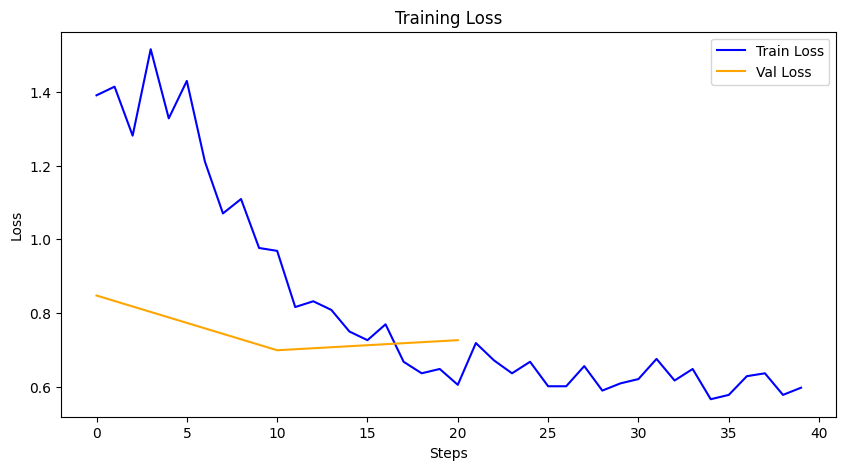

In [68]:
print("Training completed!")

# Plot training curves
print("Plotting training curves...")
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.plot(train_losses, color="blue", label="Train Loss")
axs.plot(
    np.arange(0, len(val_losses)) * yaml_config.eval_every,
    val_losses,
    color="orange",
    label="Val Loss",
)
axs.set_title("Training Loss")
axs.set_xlabel("Steps")
axs.set_ylabel("Loss")
axs.legend()
plt.savefig("training_curves.png")
plt.show()